# Here we perform regression on the polynomial features dataset

In [2]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set()

from google.colab import drive
drive.mount('/content/drive')

sys.path.append("/content/drive/MyDrive/GSOC-NMR-project/Work/Notebooks")
from auxillary_functions import *
from polynomial_featextract import poly_featextract

Mounted at /content/drive


In [3]:
# import raw data and params.txt file
datadir_path = "/content/drive/MyDrive/GSOC-NMR-project/Work/Data/2021-06-21_classify_datagen_all_funcs"

rawdata = load_data(datadir_path)
params = load_params(datadir_path)
ker_integrals = load_wlist(datadir_path) # load wlist.txt file

# Stencil type : {'0' : 'Gaussian', '1' : 'Power Law', '2' : 'RKKY'}

Finished loading rawdata into numpy array
Finsihed loading parameters file
finished loading kernel-integrals file.


In [4]:
print(rawdata.shape)
offset = 150
shifted_data, center = get_window(rawdata,2/3,width=offset)
print("The Echo pulse occurs at timestep:",center)

# Rescaled data
rscl_data = shifted_data / np.max(shifted_data,axis=1,keepdims=True)

(10500, 943)
The Echo pulse occurs at timestep: 628


(array([1459.,  335.,  373.,   93.,   10.,  302.,  876., 2453.,  976.,
        3623.]),
 array([  0. ,  29.9,  59.8,  89.7, 119.6, 149.5, 179.4, 209.3, 239.2,
        269.1, 299. ]),
 <a list of 10 Patch objects>)

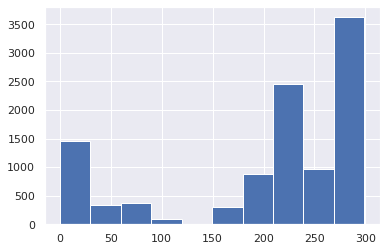

In [15]:
plt.hist(np.argmin(rscl_data, axis=1))

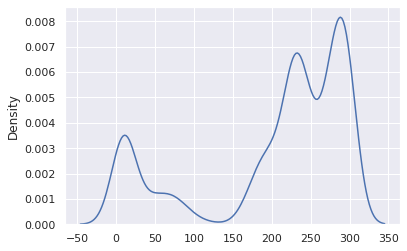

In [13]:
sns.kdeplot(np.argmin(rscl_data, axis=1))

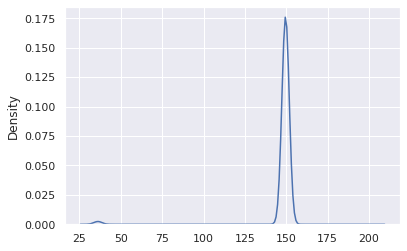

In [12]:
sns.kdeplot(np.argmax(rscl_data, axis=1))

In [ ]:
pd.options.mode.chained_assignment = None

y_classes = params[['αx','αz','ξ']]
y_classes['len_scale'] = np.sqrt(ker_integrals.values.flatten()/(params['αx'].values+1))
y_classes.head()

,αx,αz,ξ,len_scale
0,0.000140,0.004113,2.038144,0.230070
1,0.000288,0.005442,1.698081,0.220174
2,0.000948,0.000869,2.757263,0.251400
3,0.008380,0.014527,1.236614,0.343557
4,0.000710,0.013350,1.144264,0.214364


In [ ]:
%time polyfeats = poly_featextract(rscl_data, n_splits=[4,5,10], order_fits=[3,3,3], as_df=True)

CPU times: user 31 s, sys: 672 ms, total: 31.7 s
Wall time: 31 s


# Base RF model for regression

In [ ]:
from sklearn.model_selection import RepeatedKFold, GridSearchCV, train_test_split, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

In [ ]:
?cross_val_score

In [ ]:
rf = RandomForestRegressor(n_estimators=40, oob_score=True, n_jobs=-1)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

In [ ]:
cross_validate(rf, polyfeats, y_classes['αx'], n_jobs=-1)

{'fit_time': array([21.56022525, 21.64614177, 21.3169713 , 21.09920454, 10.20645332]),
 'score_time': array([0.10415745, 0.10412884, 0.10535884, 0.10404634, 0.10351348]),
 'test_score': array([0.85950239, 0.92424141, 0.93103745, 0.96769547, 0.94133152])}

In [ ]:
results=[]
for col in y_classes.columns.tolist():
    rf_scores = cross_validate(rf, polyfeats, y_classes[col],
                         scoring=['neg_mean_absolute_error','r2'],
                        cv=cv, verbose=1, n_jobs=-1)
    print(f"For {col}: ")
    print(rf_scores)
    results.append(rf_scores)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


For αx: 
{'fit_time': array([21.36280107, 21.36349773, 21.82488441, 21.32947588, 21.45662332,
       21.01243019, 20.92603064, 20.9112525 , 21.9444747 , 21.99272823,
       21.49130177, 21.61849475, 22.05542636, 21.51803708, 10.81492662]), 'score_time': array([0.10508728, 0.10570455, 0.12557697, 0.10499573, 0.10514641,
       0.10453653, 0.10478497, 0.10432315, 0.10472012, 0.10420418,
       0.10997748, 0.10534477, 0.10514164, 0.1055696 , 0.10413361]), 'test_neg_mean_absolute_error': array([-0.00039085, -0.00037804, -0.00040193, -0.00038929, -0.00037835,
       -0.00037441, -0.00040651, -0.00039232, -0.0003821 , -0.00039031,
       -0.00037908, -0.00036542, -0.00040613, -0.00038778, -0.00038887]), 'test_r2': array([0.96486355, 0.97063348, 0.96409095, 0.96781991, 0.97026971,
       0.96937095, 0.96122158, 0.96890123, 0.96721108, 0.96888252,
       0.96770691, 0.97070658, 0.96373327, 0.96712706, 0.96916896])}


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


For αz: 
{'fit_time': array([22.52603316, 22.18082213, 22.26587677, 21.92516875, 22.34840202,
       22.36007738, 21.95608592, 21.98972154, 22.24622726, 22.30535412,
       22.23195076, 22.28549838, 22.46373582, 22.50591803, 11.40766883]), 'score_time': array([0.12864494, 0.10501385, 0.1054709 , 0.1052897 , 0.10502172,
       0.10556149, 0.10394788, 0.10454631, 0.1045177 , 0.10542893,
       0.10731721, 0.10500264, 0.10511661, 0.10551548, 0.10404992]), 'test_neg_mean_absolute_error': array([-0.00043635, -0.00044245, -0.0004483 , -0.00044543, -0.00044795,
       -0.00044672, -0.000413  , -0.00045128, -0.0004518 , -0.00045732,
       -0.00044208, -0.00044401, -0.00044532, -0.0004234 , -0.00042923]), 'test_r2': array([0.96603976, 0.9699491 , 0.96820371, 0.96892604, 0.96769778,
       0.96606401, 0.97166674, 0.96815828, 0.96710011, 0.96700097,
       0.96740222, 0.96894793, 0.96698877, 0.9711477 , 0.97253843])}


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


For ξ: 
{'fit_time': array([25.61101246, 25.67061424, 25.71719813, 26.02064252, 25.43740797,
       26.11246419, 25.31045771, 25.71423626, 26.30337477, 25.51886415,
       25.41651583, 26.81026983, 25.00079966, 26.03214192, 14.48707747]), 'score_time': array([0.10503078, 0.10456777, 0.10558796, 0.12819672, 0.13278127,
       0.13473701, 0.13624334, 0.12698865, 0.10526276, 0.12772894,
       0.1246922 , 0.10543895, 0.12804198, 0.12440586, 0.10440159]), 'test_neg_mean_absolute_error': array([-0.10028011, -0.07929003, -0.1139539 , -0.09118347, -0.09655255,
       -0.09053208, -0.09895264, -0.08526926, -0.09535008, -0.09659269,
       -0.09935972, -0.09086808, -0.09744237, -0.09030813, -0.09295513]), 'test_r2': array([0.92834934, 0.94301399, 0.90365795, 0.9333119 , 0.92020176,
       0.92810011, 0.93917133, 0.94210394, 0.9198939 , 0.91256498,
       0.90942426, 0.93527864, 0.93246513, 0.93171797, 0.93064663])}
For len_scale: 
{'fit_time': array([24.97245193, 25.02109313, 25.93130922, 25.11

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.2min finished


In [ ]:
pd.DataFrame(results).to_csv("/content/drive/MyDrive/GSOC-NMR-project/Work/regression_data.csv")

In [ ]:
r2_scores_mean = [np.mean(results[i]['test_r2']) for i in range(4)]
r2_scores_std = [np.std(results[i]['test_r2']) for i in range(4)]

nMAE_scores_mean = [np.mean(results[i]['test_neg_mean_absolute_error']) for i in range(4)]
nMAE_scores_std = [np.std(results[i]['test_neg_mean_absolute_error']) for i in range(4)]

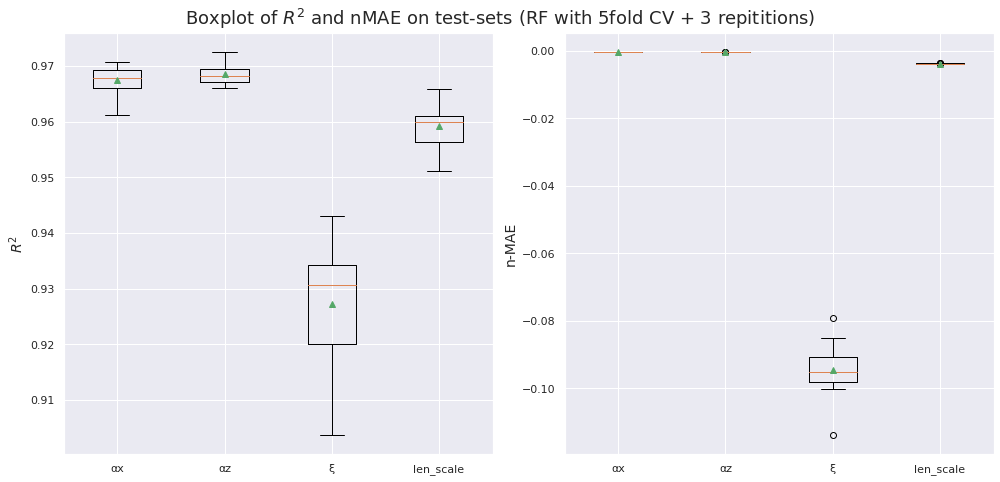

In [ ]:
fig, axes = plt.subplots(1,2,sharex=True, figsize=(14,7))
ylabel=['$R^2$', 'n-MAE']
axes[0].boxplot([results[i]['test_r2'] for i in range(4)], showmeans=True)
axes[1].boxplot([results[i]['test_neg_mean_absolute_error'] for i in range(4)], showmeans=True)

for idx, ax in enumerate(axes):
    plt.xticks(np.arange(1,5), y_classes.columns.tolist())
    ax.set_ylabel(ylabel[idx],fontsize=14)

plt.suptitle("Boxplot of $R^2$ and nMAE on test-sets (RF with 5fold CV + 3 repititions)", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Regression adn scatterplot

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(polyfeats,
                                                    y_classes, 
                                                    stratify=params['stencil_type'],
                                                    test_size=0.3, random_state=1)

In [ ]:
models = {}
for col in y_classes.columns.tolist():
    rf = RandomForestRegressor(n_estimators=40, oob_score=True, n_jobs=-1)
    rf.fit(X_train, y_train[col])
    models[col] = rf

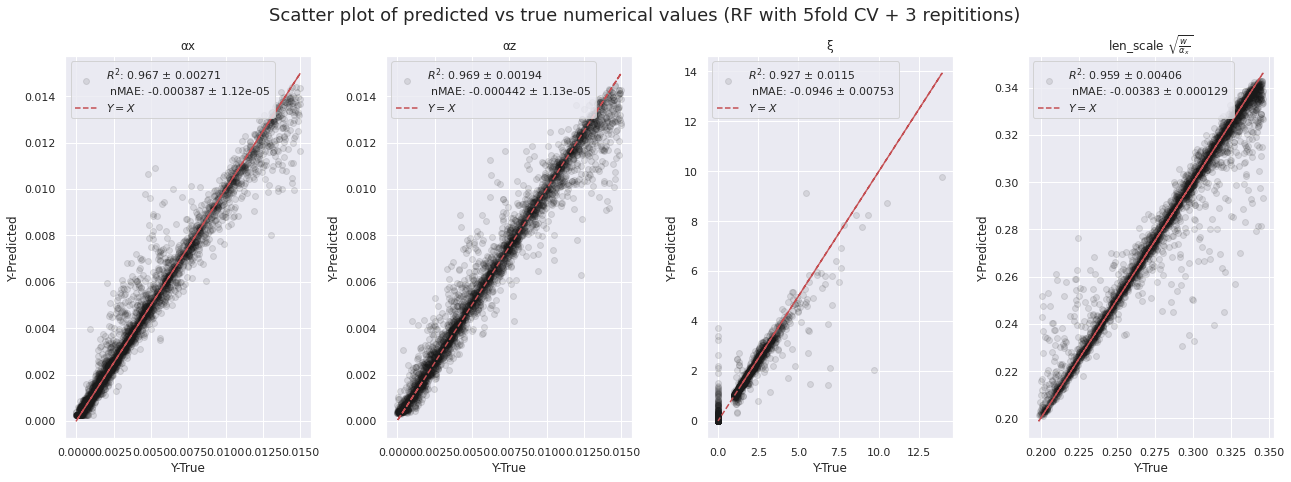

In [ ]:
# print predictions
fig, axes = plt.subplots(1,4,figsize=(18,7))
cols = y_classes.columns.tolist()

for idx,ax in enumerate(axes):
    ax.plot(y_test[cols[idx]], models[cols[idx]].predict(X_test),'ko',alpha=0.1,
            label=f'$R^2$: {r2_scores_mean[idx]:.3} $\pm$ {r2_scores_std[idx]:.3} \n nMAE: {nMAE_scores_mean[idx]:.3} $\pm$ {nMAE_scores_std[idx]:.3}')

    ax.plot(y_test[cols[idx]], y_test[cols[idx]], 'r--', label='$Y=X$')
    ax.set(xlabel='Y-True',ylabel='Y-Predicted',
           title=y_classes.columns.tolist()[idx])
    ax.legend(loc='upper left')
    
axes[-1].set_title(r"len_scale $\sqrt{\frac{w}{\alpha _x}}$")
plt.suptitle("Scatter plot of predicted vs true numerical values (RF with 5fold CV + 3 repititions)", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## The length-scale parameter $\xi$ looks fishy!

- Possible solution : 
    - $\xi$ has a lot of 0s where the model might not have understood
    - regression after classification ?

### Understand feature importances

In [ ]:
def get_fi_df(label): return pd.DataFrame(models[label].feature_importances_ , index = polyfeats.columns, columns=['fimp'])

In [ ]:
xi_fi_df, ax_fi_df, az_fi_df, ls_fi_df = list(map(get_fi_df, ['ξ','αx','αz','len_scale']))

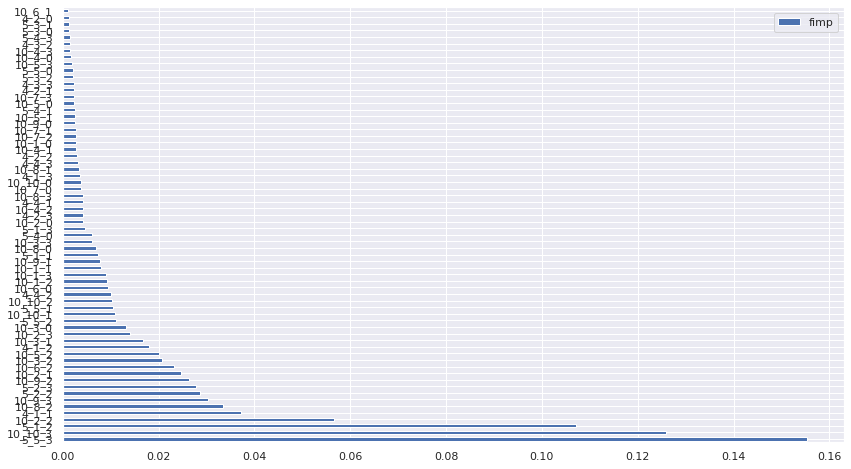

In [ ]:
xi_fi_df.sort_values('fimp',ascending=False).plot.barh(figsize=(14,8))

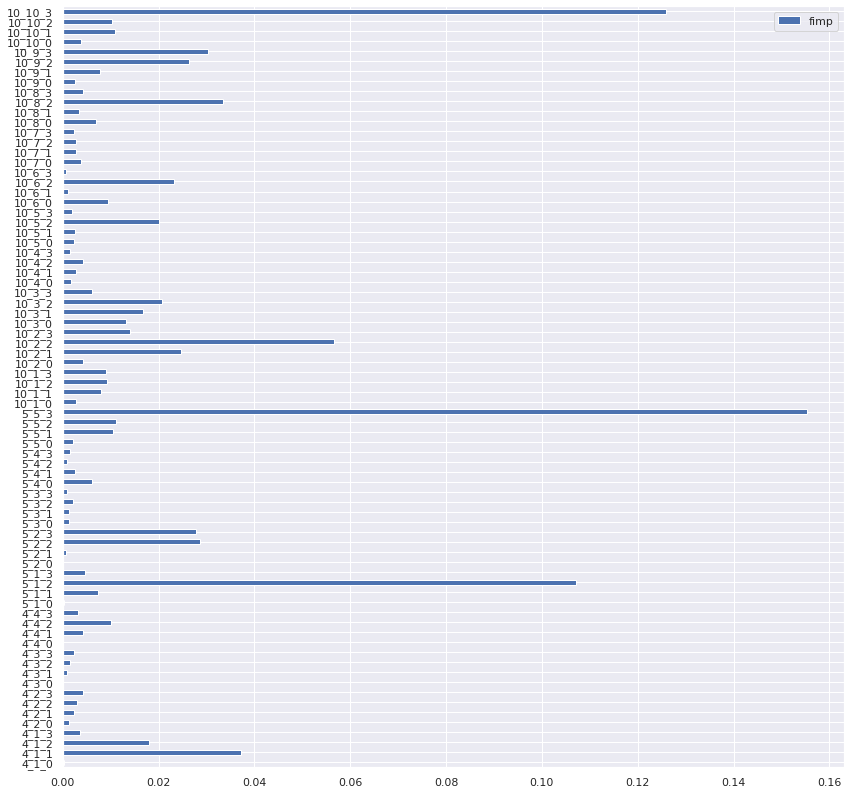

In [ ]:
xi_fi_df.plot.barh(figsize=(14,14))